# Kalman Filter Design for Pmod Nav

Simulate Pmod Nav Sensor to test Kalman Filter. Initialized with angle position, angle rate and noise standard deviation. Each call to `read()` updates the position by one time step and returns the new measurement.

In [2]:
from numpy.random import randn

class NavSensor(object):
    def __init__(self, angle=(0, 0, 0), angle_rate=(0, 0 ,0), noise_std=1.):
        self.angle_rate = angle_rate
        self.noise_std = noise_std
        self.angle = [angle[0], angle[1], angle[2]]
        
    def read(self):
        self.angle[0] += self.angle_rate[0]
        self.angle[1] += self.angle_rate[1]
        self.angle[2] += self.angle_rate[2]
        
        return [self.angle[0] + randn() * self.noise_std,
                self.angle[1] + randn() * self.noise_std,
                self.angle[2] + randn() * self.noise_std]

Testing that sensor simulation works

In [3]:
import matplotlib.pyplot as plt
import numpy as np

angle, angle_rate = (0, 0, 0), (1, 5, 10)
sensor = NavSensor(angle, angle_rate, noise_std=1)
ns = np.array([sensor.read() for _ in range(50)])
x_line = np.linspace(0,50)
plt.plot(x_line,ns[:, 0]);
plt.plot(x_line,ns[:, 1]);
plt.plot(x_line,ns[:, 2]);

Below are the steps that I've taken to design Kalman filter

### Choose the State Variables

Recall that the Kalman filter state transition must be written as $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} + \mathbf{Gw}$, which means we must calculate the current state from the previous state. The matrix $\mathbf{B}$ models how the control inputs affect the behavior of the system. The vector $\mathbf{u}$ lets you specify a control input into the filter. $\mathbf{w}$ is white noise with known covariance. For our sensor the control input will be gravity. For now, we design the state variable to be

$$
\mathbf x = 
\begin{bmatrix}\phi & r_\phi & \theta & r_\theta & \psi & r_\psi
\end{bmatrix}^\mathsf T
$$

$\phi$ $\theta$ $\psi$ represent Euler
angles with respect to the inertial frame (roll, pitch, yaw)


$r_\phi$ $r_\theta$ $r_\psi$ represent Euler angle rates with respect to the inertial frame (gyroscope)

----------------------------------------------------------
Other variable descriptions:

$u$ $v$ $w$ represent acceleration expressed in the body frame (accelerometer)

### Design State Transition Function

Our next step is to design the state transition function. Recall that the state transition function is implemented as a matrix $\mathbf F$ that we multiply with the previous state of our system to get the next state, or prior $\bar{\mathbf x} = \mathbf{Fx}$.

State equations for Euler angles


$$
\begin{aligned}
\bar \phi &= (1 * \phi) + (\Delta t * r_\phi) + (0*\theta) + (0*r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar r_\phi &= (0 * \phi) + (1 * r_\phi) + (0*\theta) + (0*r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar \theta &= (0*\phi) + (0* r_\phi) + (1 * \theta) + (\Delta t * r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar r_\theta &= (0*\phi) + (0* r_\phi) + (0 * \theta) + (1 * r_\theta) + (0*\psi) + (0*r_\psi) \\
\bar \psi &= (0*\phi) + (0*r_\phi) + (0*\theta) + (0*r_\theta) + (1 * \psi) + (\Delta t * r_\psi) \\
\bar r_\psi &= (0*\phi) + (0*r_\phi) + (0*\theta) + (0*r_\theta) + (0 * \psi) + (1 * r_\psi) \\
\end{aligned}
$$

Converting to matrix-vector form:

$$
\begin{bmatrix}\bar \phi \\ \bar r_\phi \\ \bar \theta \\ \bar r_\theta \\ \bar \psi \\ \bar r_\theta \end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0 & 0 & 0\\0& 1& 0& 0 &0 & 0\\0& 0& 1& \Delta t & 0 & 0\\ 0& 0& 0& 1 &0 &0 \\0&0&0&0&1& \Delta t\\ 0&0&0&0&0&1\end{bmatrix}\begin{bmatrix}\phi \\ r_\phi \\ \theta \\ r_\theta \\ \psi \\ r_\psi \end{bmatrix}$$

In [4]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=6, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1,  dt, 0,  0,  0, 0],
                      [0,  1,  0,  0,  0, 0],
                      [0,  0,  1,  dt, 0, 0],
                      [0,  0,  0,  1,  0, 0],
                      [0,  0,  0,  0,  1, dt],
                      [0,  0,  0,  0,  0, 1]])

### Design the Process Noise Matrix

FilterPy can compute the $\mathbf Q$ matrix for us. For simplicity I will assume the noise is a discrete time Wiener process - that it is constant for each time period. This assumption allows me to use a variance to specify how much I think the model changes between steps.

In [5]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=3, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.00025 0.0005  0.0005  0.      0.      0.     ]
 [0.0005  0.001   0.001   0.      0.      0.     ]
 [0.0005  0.001   0.001   0.      0.      0.     ]
 [0.      0.      0.      0.00025 0.0005  0.0005 ]
 [0.      0.      0.      0.0005  0.001   0.001  ]
 [0.      0.      0.      0.0005  0.001   0.001  ]]


### Design the Measurement Function

The measurement function $\mathbf H$ defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. In this case we have measurements for ($r_\phi,r_\theta,r_\psi$), so we will design $\mathbf z$ as $\begin{bmatrix}r_\phi & r_\theta & r_\psi \end{bmatrix}^\mathsf T$ which is dimension 3x1. Our state variable is size 6x1. We can deduce the required size for $\textbf{H}$ by recalling that multiplying a matrix of size MxN by NxP yields a matrix of size MxP. Thus,

$$(3\times 1) = (a\times b)(6 \times 1) = (3\times 6)(6\times 1)$$

So, $\textbf{H}$ is 3x6.

$$\mathbf H =
\begin{bmatrix} 
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}
$$

Note: Consider using bit precision conversion number here

In [6]:
tracker.H = np.array([[0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 1]])

### Design the Measurement Noise Matrix

We assume that the $r_\phi$, $r_\theta$ and $r_\psi$ variables are independent white Gaussian processes. For now let's set the variance for $r_\phi$, $r_\theta$ and $r_\psi$ .2g . They are independent, so there is no covariance, and our off diagonals will be 0. This gives us:

$$\mathbf R = \begin{bmatrix}\sigma r_\phi^2 & \sigma r_\phi \sigma r_\theta &\sigma r_\phi \sigma r_\psi \\ \sigma r_\theta \sigma r_\phi & \sigma r_\theta^2 & \sigma r_\theta \sigma r_\psi \\ \sigma r_\psi \sigma r_\phi & \sigma r_\psi \sigma r_\theta & \sigma r_\psi^2
\end{bmatrix} 
= \begin{bmatrix}.2&0&0\\0&.2&0\\0&0&.2\end{bmatrix}$$

It is a $3{\times}3$ matrix because we have 3 sensor inputs, and covariance matrices are always of size $n{\times}n$ for $n$ variables. In Python we write:

In [7]:
tracker.R = np.array([[.2, 0, 0],
                      [0, .2, 0],
                      [0, 0, .2]])
tracker.R

array([[0.2, 0. , 0. ],
       [0. , 0.2, 0. ],
       [0. , 0. , 0.2]])

### Initial Conditions

Initialize state variables to euler angles (0,0,0) and euler angle rates to (0,0,0). To start off we will also set the covariance matrix to large values

$$ \mathbf x = \begin{bmatrix}0\\0\\0\\0\\0\\0\end{bmatrix}, \,
\mathbf P = \begin{bmatrix}500&0&0&0&0&0\\0&500&0&0&0&0\\0&0&500&0&0&0\\0&0&0&500&0&0\\0&0&0&0&500&0\\0&0&0&0&0&500\end{bmatrix}$$

The Python implementation is

In [8]:
tracker.x = np.array([[0, 0, 0, 0, 0, 0]]).T
tracker.P = np.eye(6) * 500.

### Implement the Filter

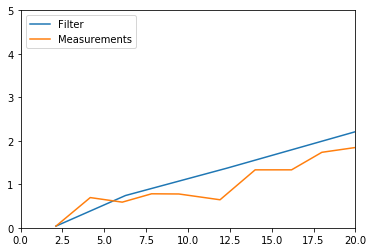

In [20]:
from filterpy.stats import plot_covariance_ellipse


R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=6, dim_z=3)
    dt = 1.0   # time step

    tracker.F = np.array([[1,  dt, 0,  0,  0, 0],
                      [0,  1,  0,  0,  0, 0],
                      [0,  0,  1,  dt, 0, 0],
                      [0,  0,  0,  1,  0, 0],
                      [0,  0,  0,  0,  1, dt],
                      [0,  0,  0,  0,  0, 1]])
    
    tracker.u = 0.
    tracker.H = np.array([[0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 1]])

    tracker.R = np.eye(3) * R_std**2
    q = Q_discrete_white_noise(dim=3, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0, 0, 0]]).T
    tracker.P = np.eye(6) * 500.
    return tracker

# simulate copter movement
N = 30
sensor = NavSensor((0, 0, 0), (2, .2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
copter_tracker = tracker1()
mu, cov, _, _ = copter_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of phi, theta, and psi
    cov = np.array([[P[0, 0], P[0, 1], P[0, 2]], 
                    [P[1, 0], P[1, 1]], P[1, 2],
                    [P[2, 0], P[2, 1]], P[2, 2]])
    mean = (x[0, 0], x[1, 0], x[2, 0])
    #plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
plt.plot(mu[:, 0], mu[:, 2],label='Filter')
plt.plot(zs[:, 0], zs[:, 1],label='Measurements')
plt.legend(loc=2)
plt.xlim(0, 20);
plt.ylim(0, 5);

## References

[1] https://www.aero.psu.edu/avia/pubs/dissertation_ss.pdf

[2] https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

[3] https://www.jhuapl.edu/techdigest/TD/td3102/31_02-Barton.pdf